# A Bayesian approach towards daily pan-Arctic sea ice freeboard observations from combined CryoSat-2 and Sentinel-3 satellites: Figures

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
from mpl_toolkits.basemap import Basemap
from scipy import stats
import matplotlib as mpl
from scipy.spatial.distance import squareform,pdist,cdist
import scipy.optimize
from netCDF4 import Dataset
from scipy.interpolate import griddata
import pickle
from numpy.linalg import multi_dot as mdot
import glob
import datetime

%matplotlib inline


def readFB(grid_res,season):
    """
    Read the input freeboard data (from all satellites) and sea ice extent (sie) mask.
    Returns:
        obs: array containing gridded freeboard information from all satellites
             of size (x,y,n,t), where n is the number of satellites (e.g., CS2 SAR,
             CS2 SARIN, S3A and S3B), and t is the number of days of observations
        sie_mask: array of daily sea ice extent of size (x,y,t), used to determine
                  which grid cells to interpolate to on a given day
        dates_trim: list dates (yyyymmdd) for which there are observations
    """
    f = open(datapath+'/CS2_SAR/CS2_SAR_dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
    CS2_SAR = pickle.load(f)
    f = open(datapath+'/CS2_SARIN/CS2_SARIN_dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
    CS2_SARIN = pickle.load(f)
    f = open(datapath+'/S3A/S3A_dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
    S3A = pickle.load(f)
    f = open(datapath+'/S3B/S3B_dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
    S3B = pickle.load(f)
    f = open(datapath+'/SIE_masking_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
    SIE = pickle.load(f)
    f.close()
    obs = []
    zb = []
    dates = []
    for key in CS2_SAR:
        if (key in CS2_SARIN) & (key in S3A) & (key in S3B):
            obs.append([CS2_SAR[key],CS2_SARIN[key],S3A[key],S3B[key]])
            zb.append(SIE[key])
            dates.append(key)
    obs = np.array(obs).transpose(2,3,1,0)
    zb = np.array(zb).transpose(1,2,0)
    zb[zb<0.15] = np.nan
    return obs,zb,dates

def GPR(x,y,xs,ell,sf2,sn2,mean,approx=False,M=None,returnprior=False):
    """
    Gaussian process regression function to predict radar freeboard
    Inputs:
            x: training data of size n x 3 (3 corresponds to x,y,time)
            y: training outputs of size n x 1 (observations of radar freeboard)
            xs: test inputs of size ns x 3
            ell: correlation length-scales of the covariance function (vector of length 3)
            sf2: scaling pre-factor for covariance function (scalar)
            sn2: noise variance (scalar)
            mean: prior mean (scalar)
            approx: Boolean, whether to use Nyström approximation method
            M: number of training points to use in Nyström approx (integer scalar)
    Returns:
            fs: predictive mean
            sfs2: predictive variance
            np.sqrt(Kxs[0][0]): prior variance
    """
    n = len(y)
    Kxsx = SGPkernel(x,xs=xs,ell=ell,sigma=sf2)
    Kxs = SGPkernel(xs,ell=ell,sigma=sf2)
        
    if approx:
        if M is None:
            M = int(n/5)
        Ki,A = Nystroem(x,y,M=M,ell=ell,sf2=sf2,sn2=sn2)
        err = mdot([Kxsx.T,Ki,Kxsx])
    else:
        Kx = SGPkernel(x,ell=ell,sigma=sf2) + np.eye(n)*sn2
        L = np.linalg.cholesky(Kx)
        A = np.linalg.solve(L.T,np.linalg.solve(L,y))
        v = np.linalg.solve(L,Kxsx)
        err = np.dot(v.T,v)
        
    fs = mean + np.dot(Kxsx.T,A)
    sfs2 = np.sqrt((Kxs - err).diagonal())
    if returnprior:
        return fs,sfs2,np.sqrt(Kxs[0][0])
    else:
        return fs,sfs2

def Nystroem(x,y,M,ell,sf2,sn2,seed=20,opt=False):
    """
    Nyström approximation for kernel machines, e.g., Williams
    and Seeger, 2001. Produce a rank 'M' approximation of K
    and find its inverse via Woodbury identity. This is a 
    faster approach of making predictions, but performance will
    depend on the value of M.
    """
    np.random.seed(seed)
    n = len(y)
    randselect = sorted(np.random.choice(range(n), M, replace=False))
    Kmm = SGPkernel(x[randselect,:],ell=ell,sigma=sf2)
    Knm = SGPkernel(x,xs=x[randselect,:],ell=ell,sigma=sf2)
    Vi = np.eye(n)/sn2

    s,u = np.linalg.eigh(Kmm)
    s[s<=0] = 1e-12
    s_tilde = n*s/M
    u_tilde = np.sqrt(M/n)*np.dot(Knm,u)/s
    L = np.linalg.cholesky(np.diag(1/s_tilde) + mdot([u_tilde.T,Vi,u_tilde]))
    alpha = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(u_tilde.T,Vi)))
    Ki = Vi - mdot([Vi,u_tilde,alpha]) #using Woodbury identity
    if opt:
        L_tilde = np.sqrt(s_tilde)*u_tilde
        det = np.linalg.slogdet(np.eye(M)*sn2 + np.dot(L_tilde.T,L_tilde))
        return Ki,np.atleast_2d(np.dot(Ki,y)).T,(det[0]*det[1])/2
    else:
        return Ki,np.atleast_2d(np.dot(Ki,y)).T
    
def SGPkernel(x,xs=None,grad=False,ell=1,sigma=1):
    """
    Return a Matern (3/2) covariance function for the given inputs.
    Inputs:
            x: training data of size n x 3 (3 corresponds to x,y,time)
            xs: test inputs of size ns x 3
            grad: Boolean whether to return the gradients of the covariance
                  function
            ell: correlation length-scales of the covariance function
            sigma: scaling pre-factor for covariance function
    Returns:
            sigma*k: scaled covariance function
            sigma*dk: scaled matrix of gradients
    """
    if xs is None:
        Q = squareform(pdist(np.sqrt(3.)*x/ell,'euclidean'))
        k = (1 + Q) * np.exp(-Q)
        dk = np.zeros((len(ell),k.shape[0],k.shape[1]))
        for theta in range(len(ell)):
            q = squareform(pdist(np.sqrt(3.)*np.atleast_2d(x[:,theta]/ell[theta]).T,'euclidean'))
            dk[theta,:,:] = q * q * np.exp(-Q)
    else:
        Q = cdist(np.sqrt(3.)*x/ell,np.sqrt(3.)*xs/ell,'euclidean')
        k = (1 + Q) * np.exp(-Q)
    if grad:
        return sigma*k,sigma*dk
    else:
        return sigma*k

def SMLII(hypers,x,y,approx=False,M=None):
    """
    Objective function to minimise when optimising the model
    hyperparameters. This function is the negative log marginal likelihood.
    Inputs:
            hypers: initial guess of hyperparameters
            x: inputs (vector of size n x 3)
            y: outputs (freeboard values from all satellites, size n x 1)
            approx: Boolean, whether to use Nyström approximation method
            M: number of training points to use in Nyström approx (integer scalar)
    Returns:
            nlZ: negative log marginal likelihood
            dnLZ: gradients of the negative log marginal likelihood
    """
    ell = [np.exp(hypers[0]),np.exp(hypers[1]),np.exp(hypers[2])]
    sf2 = np.exp(hypers[3])
    sn2 = np.exp(hypers[4])
    n = len(y)
    Kx,dK = SGPkernel(x,grad=True,ell=ell,sigma=sf2)
    try:
        if approx:
            Ki,A,det = Nystroem(x,y,M=M,ell=ell,sf2=sf2,sn2=sn2,opt=True)
            nlZ = np.dot(y.T,A)/2 + det + n*np.log(2*np.pi)/2
            Q = Ki - np.dot(A,A.T)
        else:
            L = np.linalg.cholesky(Kx + np.eye(n)*sn2)
            A = np.atleast_2d(np.linalg.solve(L.T,np.linalg.solve(L,y))).T
            nlZ = np.dot(y.T,A)/2 + np.log(L.diagonal()).sum() + n*np.log(2*np.pi)/2
            Q = np.linalg.solve(L.T,np.linalg.solve(L,np.eye(n))) - np.dot(A,A.T)
            
        dnlZ = np.zeros(len(hypers))
        for theta in range(len(hypers)):
            if theta < 3:
                dnlZ[theta] = (Q*dK[theta,:,:]).sum()/2
            elif theta == 3:
                dnlZ[theta] = (Q*(2 * Kx)).sum()/2
            elif theta == 4:
                dnlZ[theta] = sn2*np.trace(Q)
    except np.linalg.LinAlgError as e:
        nlZ = np.inf ; dnlZ = np.ones(len(hypers))*np.inf
    return nlZ,dnlZ

    
grid_res = 25 #in km
season = '2018-2019'
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l',round=True)
datapath = '/Users/williamgregory/Documents/Datasets/Freeboard'
x = np.load(datapath+'/x_'+str(grid_res)+'km.npy') #zonal grid positions
y = np.load(datapath+'/y_'+str(grid_res)+'km.npy') #meridional grid positions
lon,lat = m(x,y,inverse=True)

T=9 #9 days of data are used to train the model. You could test varying this. Could maybe get away with 5 or 7.
T_mid=T//2 #interpolate on the central day
obs,zb,dates = readFB(grid_res,season)
dX,dY = obs.shape[0],obs.shape[1]

mplot = Basemap(llcrnrlon=-90, llcrnrlat=75, urcrnrlon=-152, urcrnrlat=82,
    resolution='l',projection='stere',lat_0=90,lon_0=0) #define a new projection to test interpolating 1 pixel
xFB,yFB = mplot(lon,lat) #zonal & meridional positions for new projection

cs2_FYI = np.load(datapath+'/CS2_25km_FYI_20181101-20190428.npy') #this contains a (x,y,t) numpy array of only first-year-ice freeboards. We use this to define the prior mean
day = 1 #training data starts at day = 1
zb_day = zb[:,:,day+T_mid] #this is the sea ice extent mask on the day we are interpolating (i.e., we need to make sure there is sea ice where we want to estimate freeboard)
sat = obs[:,:,:,day:day+T] #the T days of training data from all satellites
mean = np.nanmean(cs2_FYI[:,:,day+16:day+25]).round(3) #prior mean. The indexing +16 and +25 are a little confusing here. cs2_FYI starts on the 1st of November 2018, while the observations begin on something like the 26th of November

#this next part loops over all T days of training data and appends all the inputs/outputs into long vectors
x1 = [] ; y1 = [] ; t1 = [] ; z1 = []
x2 = [] ; y2 = [] ; t2 = [] ; z2 = []
x3 = [] ; y3 = [] ; t3 = [] ; z3 = []
x4 = [] ; y4 = [] ; t4 = [] ; z4 = []
for day in range(sat.shape[3]):
    IDs_1 = np.where(~np.isnan(sat[:,:,0,day]))
    IDs_2 = np.where(~np.isnan(sat[:,:,1,day]))
    IDs_3 = np.where(~np.isnan(sat[:,:,2,day]))
    IDs_4 = np.where(~np.isnan(sat[:,:,3,day]))
    x1.extend(xFB[IDs_1]) ; x2.extend(xFB[IDs_2]) ; x3.extend(xFB[IDs_3]) ; x4.extend(xFB[IDs_4])
    y1.extend(yFB[IDs_1]) ; y2.extend(yFB[IDs_2]) ; y3.extend(yFB[IDs_3]) ; y4.extend(yFB[IDs_4])
    t1.extend(np.ones(np.shape(IDs_1)[1])*day) ; t2.extend(np.ones(np.shape(IDs_2)[1])*day) ; t3.extend(np.ones(np.shape(IDs_3)[1])*day) ; t4.extend(np.ones(np.shape(IDs_4)[1])*day)
    z1.extend(sat[:,:,0,day][IDs_1]) ; z2.extend(sat[:,:,1,day][IDs_2]) ; z3.extend(sat[:,:,2,day][IDs_3]) ; z4.extend(sat[:,:,3,day][IDs_4])
x_train = np.concatenate((x1,x2,x3,x4))
y_train = np.concatenate((y1,y2,y3,y4))
t_train = np.concatenate((t1,t2,t3,t4))
z = np.concatenate((z1,z2,z3,z4))
xy_train = np.array([x_train,y_train]).T

IDs = np.where(~np.isnan(zb_day))
X = np.array([xFB[IDs],yFB[IDs]]).T
X_tree = scipy.spatial.cKDTree(xy_train)

#in this example we are predicting at x,y position .94e6,3.5e5
ID = X_tree.query_ball_point(x=np.array([.94e6,3.5e5]).T, r=300*1000) #find all training points within 300km radius
inputs = np.array([x_train[ID],y_train[ID],t_train[ID]]).T #training inputs
outputs = z[ID] #training outputs
n = len(outputs)
mX = np.ones(n)*mean
Xs = np.atleast_2d(np.array([.94e6,3.5e5,T_mid])) #test inputs


/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:198: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:210: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


# GPR example: 1 grid cell (Figure 2 of paper)

[2.14650441e+05 1.39918966e+05 2.10122829e+01 2.79070701e-02
 3.45738227e-03]
[0.31375957] [0.02755506]


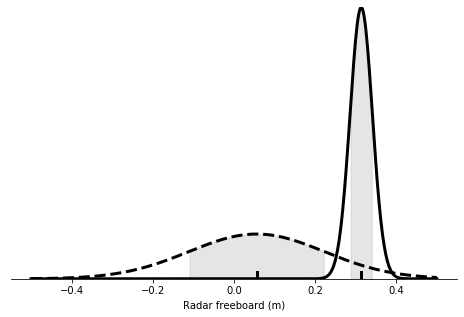

In [9]:

x0 = [np.log(grid_res*1000),np.log(grid_res*1000),np.log(1.),np.log(1.),np.log(.1)] #initial guess of hyperparameters
res = scipy.optimize.minimize(SMLII,x0=x0,args=(inputs,outputs-mX),method='CG',jac=True) #optimise hyperparameters
lx = np.exp(res.x[0]) #zonal correlation length-scale
ly = np.exp(res.x[1]) #meridional correlation length-scale
lt = np.exp(res.x[2]) #temporal correlation length-scale
sf2 = np.exp(res.x[3]) #scaling pre-factor
sn2 = np.exp(res.x[4]) #noise variance
print(np.exp(res.x))

fs,σfs,σp = GPR(inputs,outputs-mX,Xs,ell=[lx,ly,lt],\
                sf2=sf2,sn2=sn2,mean=mean,returnprior=True) #prediction mean and variance
print(fs,σfs)
fb_values = np.linspace(-.5,.5,500)
prior = stats.norm.pdf(fb_values, mean, σp)
post = stats.norm.pdf(fb_values, fs, σfs)

fig,ax = plt.subplots(1,figsize=(8,5))
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')
ax.plot(fb_values,prior,linewidth=3,color='k',linestyle='--')
ax.plot(fb_values,post,linewidth=3,color='k')
ax.axvline(fs,ymin=0,ymax=0.025,color='k',linewidth=3,alpha=1)
ax.axvline(mean,ymin=0,ymax=0.025,color='k',linewidth=3,alpha=1)

ax.fill_between(fb_values,prior,where=((fb_values>=mean-σp) & \
                                     (fb_values<=mean+σp)),color='k',alpha=.1)
ax.fill_between(fb_values,post,where=((fb_values>=fs-σfs) & \
                                     (fb_values<=fs+σfs)),color='k',alpha=.1)

ax.set_ylim(0,14.5)
ax.set_yticks([])
ax.set_xlabel('Radar freeboard (m)')
plt.show()


# Approximate matrix inverse using Nyström method

Nyström method is an approach for approximating eigenfunctions and hence also kernel functions. For an nxn kernel matrix we can produce a low-rank representation of this by choosing a random subset of m data points where m<n from the original observations. We then only need to solve a linear problem of dimension mxm. See section 8.1 of Rasmussen & Williams, 2006 for more details.

By using the Woodbury inversion lemma and Sylvester's determinant theorem we can also use optimize hyperparameters with the log marginal likelihood function

[7.94142972e+04 7.05759062e+04 2.34553779e+00 8.73427307e-03
 4.30651123e-03]
0.3153356226389836 [0.04967873]


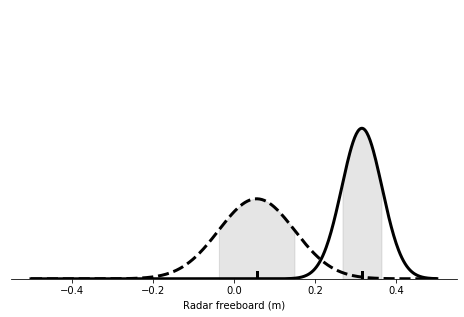

In [19]:
M = 925 #subset number of training points to use for Nyström approx.
x0 = [np.log(grid_res*1000),np.log(grid_res*1000),np.log(1.),np.log(1.),np.log(.1)] #initial guess of hyperparameters
res = scipy.optimize.minimize(SMLII,x0=x0,args=(inputs,outputs-mX,True,M),method='CG',jac=True) #optimise hyperparameters
lx = np.exp(res.x[0]) #zonal correlation length-scale
ly = np.exp(res.x[1]) #meridional correlation length-scale
lt = np.exp(res.x[2]) #temporal correlation length-scale
sf2 = np.exp(res.x[3]) #scaling pre-factor
sn2 = np.exp(res.x[4]) #noise variance
print(np.exp(res.x))

fs,σfs,σp = GPR(inputs,outputs-mX,Xs,ell=[lx,ly,lt],\
                sf2=sf2,sn2=sn2,mean=mean,returnprior=True,approx=True,M=M) #prediction mean and variance
fs = fs.squeeze()
print(fs,σfs)
fb_values = np.linspace(-.5,.5,500)
prior = stats.norm.pdf(fb_values, mean, σp)
post = stats.norm.pdf(fb_values, fs, σfs)

fig,ax = plt.subplots(1,figsize=(8,5))
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')
ax.plot(fb_values,prior,linewidth=3,color='k',linestyle='--')
ax.plot(fb_values,post,linewidth=3,color='k')
ax.axvline(fs,ymin=0,ymax=0.025,color='k',linewidth=3,alpha=1)
ax.axvline(mean,ymin=0,ymax=0.025,color='k',linewidth=3,alpha=1)

ax.fill_between(fb_values,prior,where=((fb_values>=mean-σp) & \
                                     (fb_values<=mean+σp)),color='k',alpha=.1)
ax.fill_between(fb_values,post,where=((fb_values>=fs-σfs) & \
                                     (fb_values<=fs+σfs)),color='k',alpha=.1)

ax.set_ylim(0,14.5)
ax.set_yticks([])
ax.set_xlabel('Radar freeboard (m)')
plt.show()
